In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rc('font', family='Malgun Gothic',size=8, weight = 'bold')

# 1. 데이터 가져오기

In [2]:
excel_file = pd.ExcelFile('D:\invest_work\MPAA\MPAA 데이터.xlsx')
asset_group = excel_file.sheet_names
asset_group

['국가', '섹터', '팩터', '채권', '현금']

# 2. 자산군별 데이터 프레임 설정

In [3]:
data = {}
for i in asset_group:
    data[i] = excel_file.parse(i)
    data[i].index = data[i].날짜
    data[i].drop('날짜', axis = 1, inplace=True)
    print(i+'개수',len(data[i].columns))

국가개수 12
섹터개수 26
팩터개수 30
채권개수 3
현금개수 1


# 3. 함수 설정

In [4]:
# 월간수익률
def return_month(df):
    return df / df.shift(1)

# 변동성대비모멘텀
def volatility_momentum(df):
    a = df/df.shift(12)
    b = return_month(df).rolling(12).std()
    return a/b

# 연평균수익률
def return_year(df):
    return df/df.shift(12)

# 평균모멘텀
def momentum_avg(df):
    int_val = 0
    for i in range(1, 13):
        int_val = df / df.shift(i) + int_val
    return int_val / 12

# 모멘텀순위
def momentum_rank(df, ranking):
    x = momentum_avg(df)
    y = x.iloc[ : , 0: len(x.columns)].rank(1, ascending=0)
    y[y <= ranking] = 1
    y[y > ranking] = 0
    return y

# 평균모멘텀스코어
def momentum_avg_score(df):
    a = momentum_avg(df).copy()
    int_val = 0
    for i in range(1, 13):
        int_val = np.where(df / df.shift(i) > 1, 1, 0) + int_val
    a[a > -1] = int_val/12
    return a

# 평균모멘텀스코어6
def mometum_avg_score6(df):
    a = momentum_avg(df).copy()
    int_val = 0
    for i in range(1, 7):
        int_val = np.where(df / df.shift(i) > 1, 1, 0) + int_val
    a[a > -1] = int_val/6
    return a

# 현금혼합모멘텀수익곡선
def cash_mixed_momentum_return_curve(df, cash_rate=0.25):
    x = return_month(data['현금'])*cash_rate
    a = pd.DataFrame((return_month(df).values*momentum_avg_score(df).shift(1).values+x.values)/(cash_rate+momentum_avg_score(df).shift(1).values)).cumprod() 
    a.index = df.index
    a.columns = df.columns
    return a

# 자산군통합포트
def asset_group_integrated_port(df, ranking, asset_group_rate):
    x = return_month(cash_mixed_momentum_return_curve(df))
    y = np.where(momentum_rank(df, ranking).shift(1)==0,np.nan,asset_group_rate/ranking)
    z = ((x*y).sum(1)).dropna()
    z = z.replace(0, np.nan)
    return z

# 통합모멘텀
def integrated_momentum(country_rate, sector_rate, factor_rate, bond_rate):
    a = asset_group_integrated_port(data['국가'],4,country_rate)
    b = asset_group_integrated_port(data['섹터'],8,sector_rate)
    c = asset_group_integrated_port(data['팩터'],10,factor_rate)
    d = asset_group_integrated_port(data['채권'],1,bond_rate)
    e = (pd.concat([a, b, c, d], axis=1).sum(1)/(country_rate+sector_rate+factor_rate+bond_rate))
    e = e.replace(0,np.nan).cumprod()
    e.columns = ['통합수익']
    return e

# 수익곡선모멘텀
def return_curve_momentum(country_rate, sector_rate, factor_rate, bond_rate):
    x = return_month(data['현금'])
    y = pd.DataFrame(integrated_momentum(country_rate, sector_rate, factor_rate, bond_rate), index = x.index)    
    a = pd.DataFrame((return_month(y).values*mometum_avg_score6(y).shift(1).values+(1-mometum_avg_score6(y).shift(1).values)*x.values), index = x.index).cumprod().dropna()
    return a


# 4. 결과 plot
# 국가, 섹터, 팩터, 채권

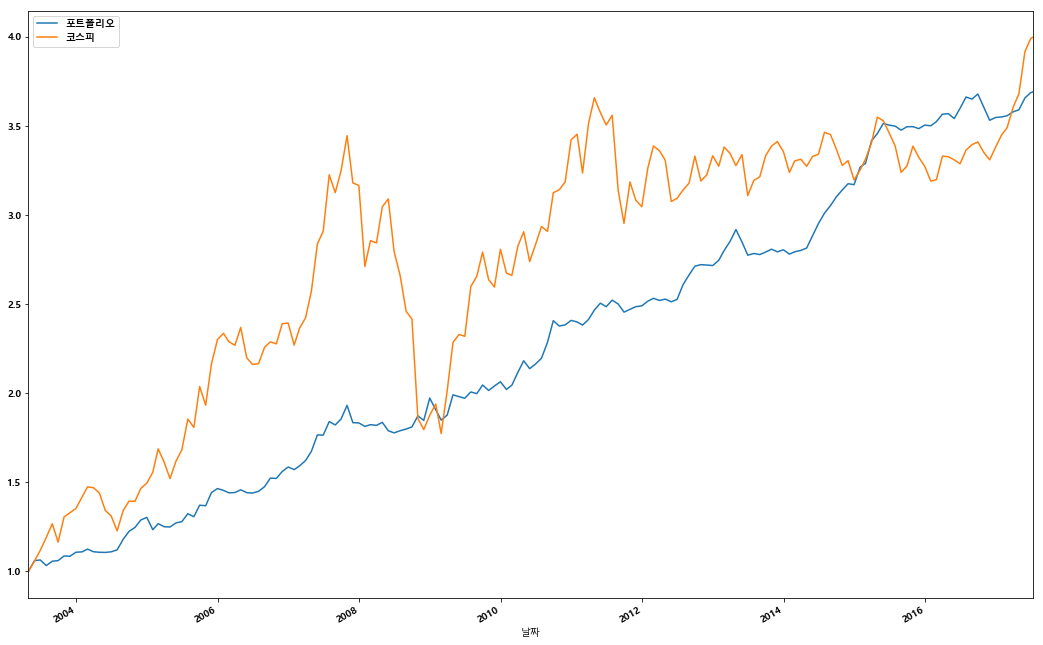

In [5]:
a = return_curve_momentum(1,1,1,3)
b = data['국가'].KOSPI/data['국가'].KOSPI.iloc[0]
c = pd.concat([a, b], axis=1).dropna()
c.columns = ['포트폴리오', '코스피']
c.divide(c.iloc[0]).plot(figsize = (18,12))
plt.show()

# 5. MDD

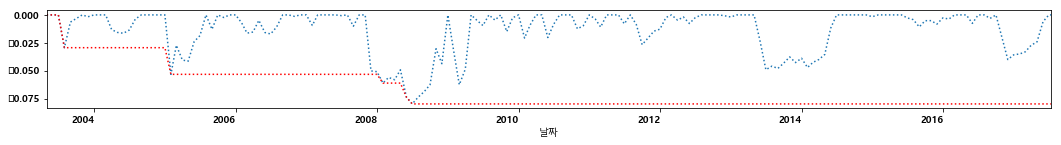

In [6]:
최대하락 = c.포트폴리오.rolling(min_periods=1, window = 500).max()
당월하락 = c.포트폴리오/최대하락 - 1.0
최대하락폭 = 당월하락.rolling(min_periods=1, window=500).min()

당월하락.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

# 6. MDD / CAGR

In [7]:
투자기간 = len(c.index)/12
print("MDD : "+str(최대하락폭.min()*100)[0:5]+"%")
print("CAGR : "+str(c.포트폴리오[-1]**(1/투자기간)*100-100)[0:4]+"%")

MDD : -7.98%
CAGR : 9.67%


In [9]:
data['국가'].head()

,S&P 500,러셀 3000,니케이 225,항셍,홍콩 H,대만 가권,상해종합,영국 FTSE 100,프랑스 CAC 40,독일 DAX,KOSPI,인도 SENSEX
날짜,,,,,,,,,,,,
2001-01-31,1366.01,749.98,13843.6,16102.4,1588.2500,5936.20,2065.61,6297.5,5998.49,6795.14,617.91,4326.72
2001-02-28,1239.94,680.52,12883.5,14787.9,1809.6300,5674.69,1959.18,5917.9,5367.48,6208.24,578.10,4247.04
2001-03-31,1160.33,635.67,12999.7,12760.6,1815.1801,5797.92,2112.78,5633.7,5180.45,5829.95,523.22,3604.38
2001-04-30,1249.46,686.12,13934.3,13386.0,2062.6499,5381.67,2119.18,5966.9,5640.03,6264.51,577.36,3519.16
2001-05-31,1255.82,690.63,13262.1,13174.4,2335.3501,5048.86,2214.26,5796.1,5454.19,6123.26,612.16,3631.91


In [25]:
data['국가'].columns

Index(['S&P 500', '러셀 3000', '니케이 225', '항셍', '홍콩 H', '대만 가권', '상해종합',
       '영국 FTSE 100', '프랑스 CAC 40', '독일 DAX', 'KOSPI', '인도 SENSEX'],
      dtype='object')

In [27]:
data['국가'].columns[0]

'S&P 500'

In [33]:
data['국가'].iloc[:,0].head()


날짜
2001-01-31    1366.01
2001-02-28    1239.94
2001-03-31    1160.33
2001-04-30    1249.46
2001-05-31    1255.82
Name: S&P 500, dtype: float64

In [37]:
df_country = data['국가']
df_country['S&P 500'].head()

날짜
2001-01-31    1366.01
2001-02-28    1239.94
2001-03-31    1160.33
2001-04-30    1249.46
2001-05-31    1255.82
Name: S&P 500, dtype: float64

# S&P 500

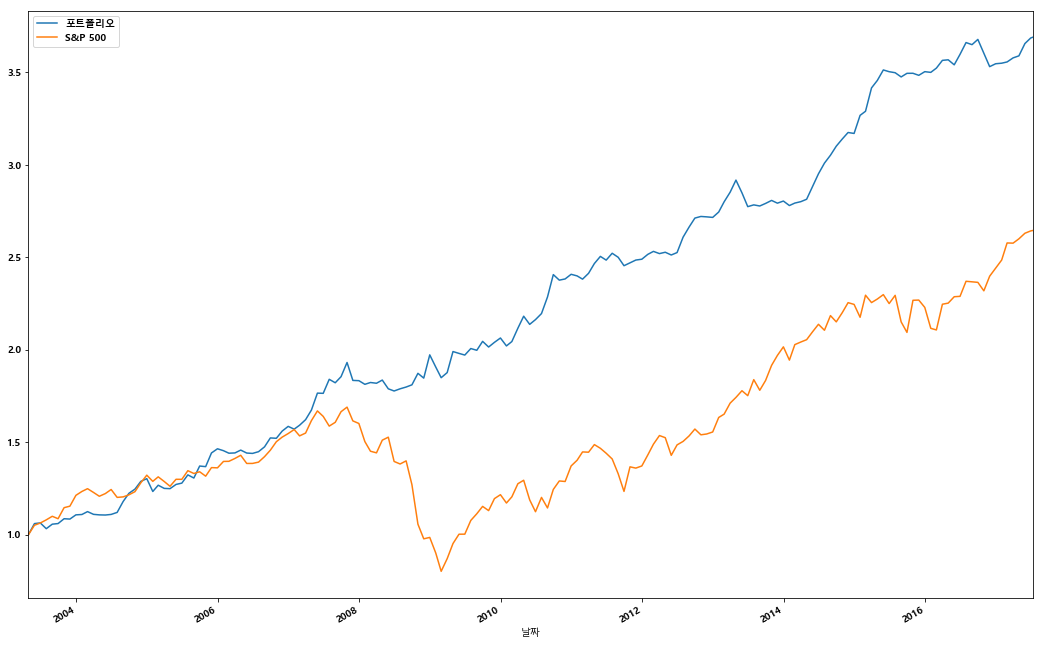

In [46]:
a2 = return_curve_momentum(1,1,1,3)
df_country2 = data['국가']
b2 = df_country2['S&P 500']/df_country2['S&P 500'].iloc[0]
c2 = pd.concat([a2, b2], axis=1).dropna()
c2.columns = ['포트폴리오', 'S&P 500']
c2.divide(c2.iloc[0]).plot(figsize = (18,12))
plt.show()

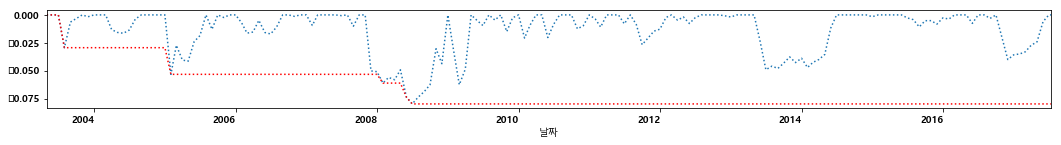

In [47]:
최대하락2 = c2.포트폴리오.rolling(min_periods=1, window = 500).max()
당월하락2 = c2.포트폴리오/최대하락2 - 1.0
최대하락폭2 = 당월하락2.rolling(min_periods=1, window=500).min()

당월하락2.plot(subplots=True, figsize = (18,2), linestyle='dotted')
최대하락폭2.plot(subplots=True, figsize = (18,2), color = 'red', linestyle='dotted')
plt.show()

In [48]:
투자기간2 = len(c2.index)/12
print("MDD : "+str(최대하락폭2.min()*100)[0:5]+"%")
print("CAGR : "+str(c2.포트폴리오[-1]**(1/투자기간)*100-100)[0:4]+"%")

MDD : -7.98%
CAGR : 9.67%
